# Test cluster stability with curlies_bridges_two_maskstim

In [121]:
%plot inline -s 640,480
workspace;

In [ ]:
% Load the data
clear;

load('/Users/M/Synced/Titan/Bench4/curlies_bridges_two_maskstim_seeded_6_25-Sep-2017.mat')

In [68]:
z = sim{3}.networkHistory.V_soma;

% Remove the beginning for better processing
z1 = double(z(:, 500:2500)');

% Data without a dc component
z2 = bsxfun(@minus, z1, mean(z1,1));

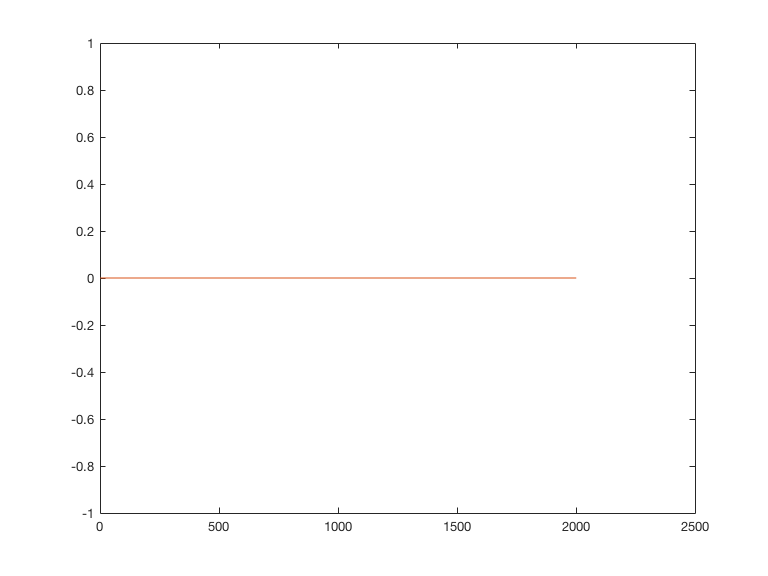

In [96]:
plot(z2(:,find(logamp<=-5.4)));

Here we first remove the non-oscllating cells.

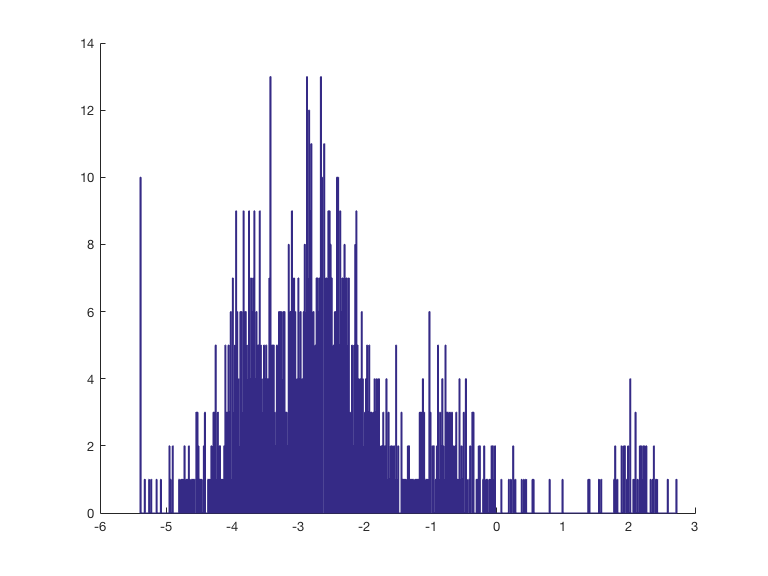

In [71]:
z3 = hilbert(z2);
logamp = log(mean(abs(z3)));
hist(logamp, 500)
box off

Two peaks at the end are from non-oscillating cells. We remove them from our data...

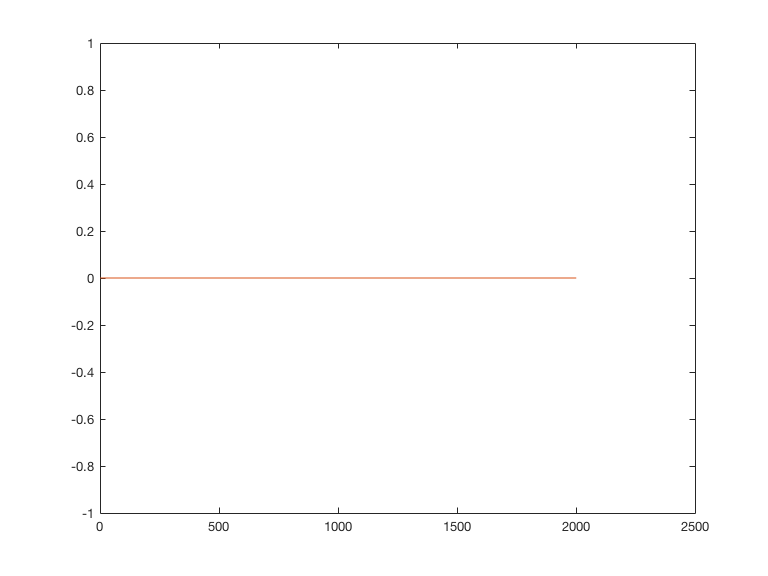

In [72]:
igood = find(logamp>=-5.4);
ibad = find(logamp<-5.4);

z4 = z2(:,igood);
plot(z2(:,ibad))

Now we compute the normalized data and (partial) correlation matrix.

In [97]:
z4 = bsxfun(@times, z4, 1./std(z4)); % Normalize the amplitude as well
z4m = mean(z4, 2);

% zn = (z4'*z4)/size(z4, 1); % either correlation
zn = partialcorr(z4, z4m); % partial correlation w.r.t the mean oscillation
zn(zn<0) = 0; % Ignore negative correlation...

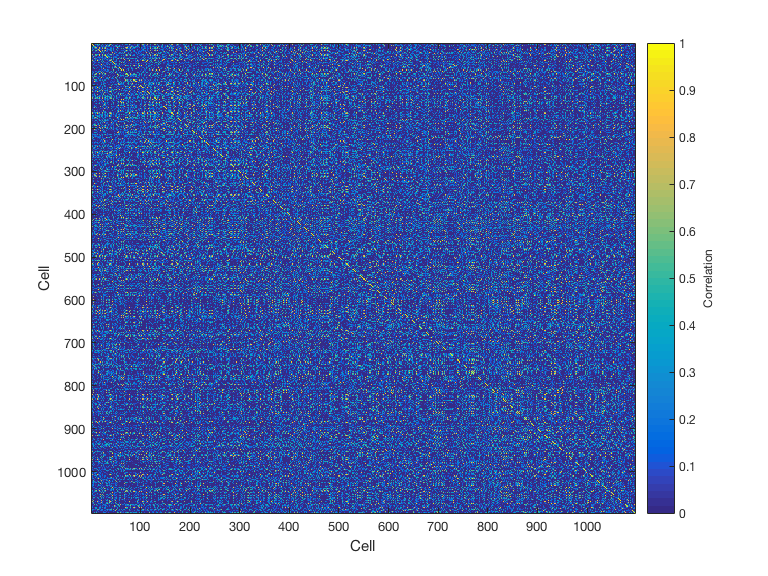

In [98]:
imagesc(zn)
xlabel('Cell')
ylabel('Cell')
c = colorbar();
c.Label.String = 'Correlation';

## Cluster stability

*Cluster stability* is a non-parametric method to determine the best number of clusters. First, we make $N_{shuffle}$ data sets from randomly drawn samples (a fraction of 80% below), obtain cluster labels with a given number of clusters for each resampled data set, and compare how well they match with each other.

In [122]:
Nshuffle = 100;
[zn2, idxz] = make_rand_samples2(zn, Nshuffle, 0.8);

In [123]:
v = spctcldata(zn);
vs = cellfun(@spctcldata, zn2, 'UniformOutput', false);

Now, we evaluate the distance of clustering results between each pair of random sample, with changing the number of clusters from 2 to 120.

In [124]:
ngrid = 100 - 1;
met = zeros(ngrid, Nshuffle*(Nshuffle-1)/2);
rmet = zeros(ngrid, Nshuffle*(Nshuffle-1)/2);
fprintf('i, Ncl\n');
for i=1:ngrid
    Ncl = i+1;
    
    % Perform clustering on the random samples
    clidx = arrayfun(@(k) spctcl(vs{k}, Ncl, 1), 1:Nshuffle, 'UniformOutput', false);
    
    % Evaluate distance between each pair
    [pd, rpd] = cij2(clidx, idxz);
    met(i,:) = pd;
    rmet(i,:) = rpd;
    
    fprintf('%d, %d\n', i, Ncl);
end

i, Ncl
1, 2
2, 3
3, 4
4, 5
5, 6
6, 7
7, 8
8, 9
9, 10
10, 11
11, 12
12, 13
13, 14
14, 15
15, 16
16, 17
17, 18
18, 19
19, 20
20, 21
21, 22
22, 23
23, 24
24, 25
25, 26
26, 27
27, 28
28, 29
29, 30
30, 31
31, 32
32, 33
33, 34
34, 35
35, 36
36, 37
37, 38
38, 39
39, 40
40, 41
41, 42
42, 43
43, 44
44, 45
45, 46
46, 47
47, 48
48, 49
49, 50
50, 51
51, 52
52, 53
53, 54
54, 55
55, 56
56, 57
57, 58
58, 59
59, 60
60, 61
61, 62
62, 63
63, 64
64, 65
65, 66
66, 67
67, 68
68, 69
69, 70
70, 71
71, 72
72, 73
73, 74
74, 75
75, 76
76, 77
77, 78
78, 79
79, 80
80, 81
81, 82
82, 83
83, 84
84, 85
85, 86
86, 87
87, 88
88, 89
89, 90
90, 91
91, 92
92, 93
93, 94
94, 95
95, 96
96, 97
97, 98
98, 99
99, 100


Examining the membrane potentials for each cluster shows that clustering is mostly driven by locking at different phases.

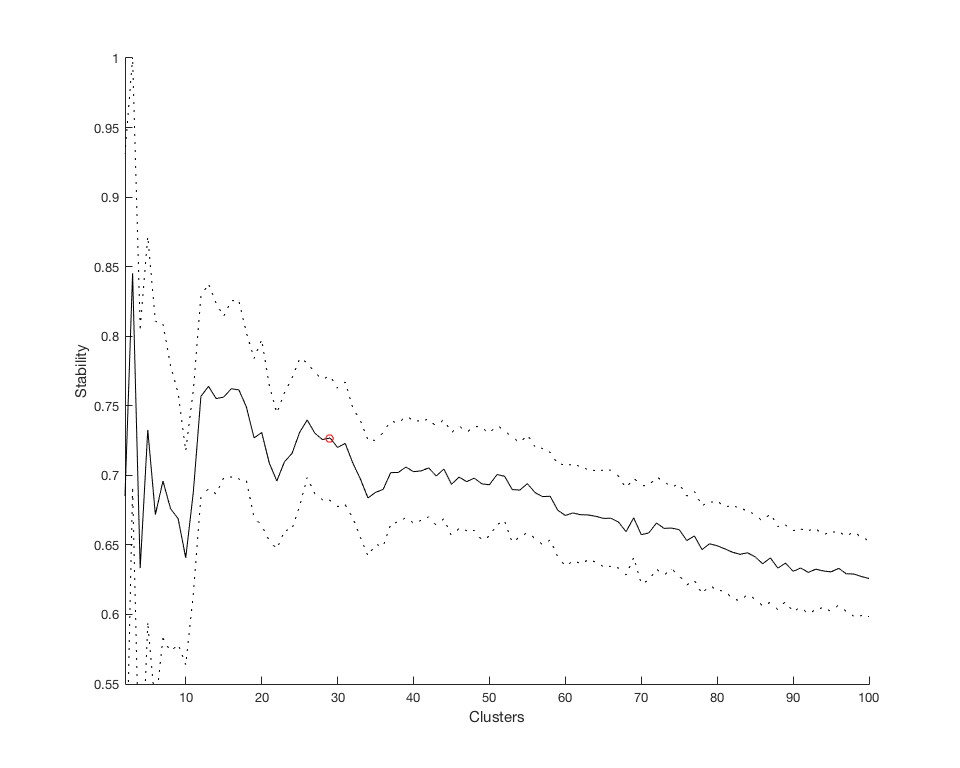

In [128]:
tcl = 2:100;
mmet = 1-mean(met'./rmet');
sdmet = std(met'./rmet');
plot(tcl, mmet+sdmet,':k',...
     tcl, mmet-sdmet,':k',...
     tcl, mmet,'k',...
     [29], mmet(28),'or')
box off
axis tight
ylim([0.55 1])
xlabel('Clusters')
ylabel('Stability')

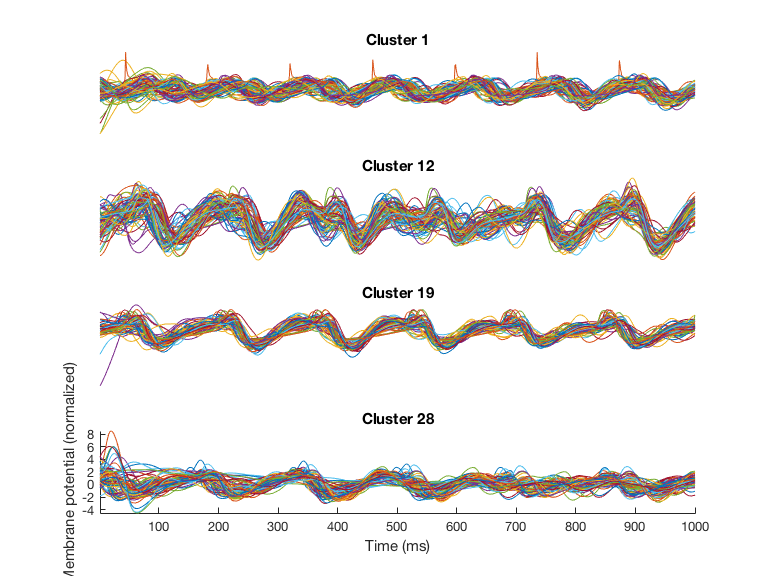

In [135]:
%plot inline -s 800,600
tt = 1:1000;
subplot(411)
plot(tt, z4(tt, idx==1))
axis tight
box off
axis off
title('Cluster 1')
subplot(412)
plot(tt, z4(tt, idx==5))
axis tight
box off
axis off
title('Cluster 12')
subplot(413)
plot(tt, z4(tt, idx==10))
axis tight
box off
axis off
title('Cluster 19')
subplot(414)
plot(tt, z4(tt, idx==15))
axis tight
box off
title('Cluster 28')
ylabel('Membrane potential (normalized)')
xlabel('Time (ms)')

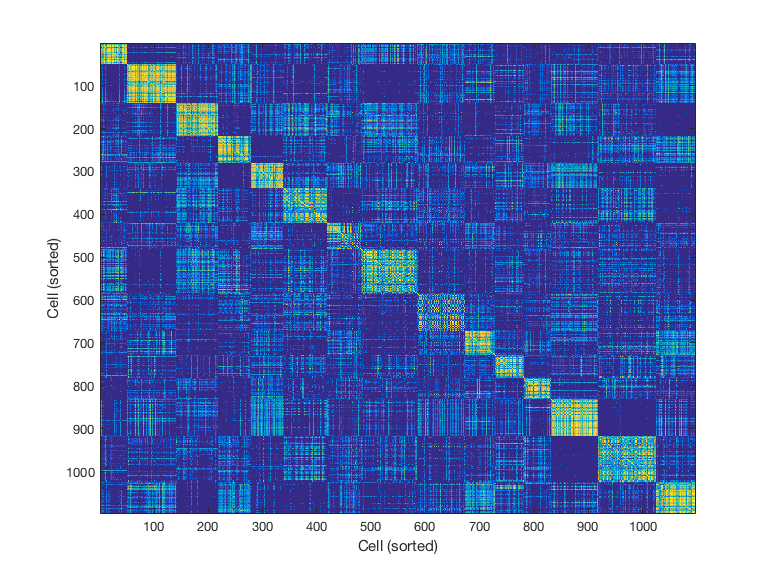

In [139]:
ncl = 15;
idx = spctcl(v, ncl, 20); %Recluster the data
[~, sidx] = sort(idx);
imagesc(zn(sidx, sidx))
xlabel('Cell (sorted)')
ylabel('Cell (sorted)')

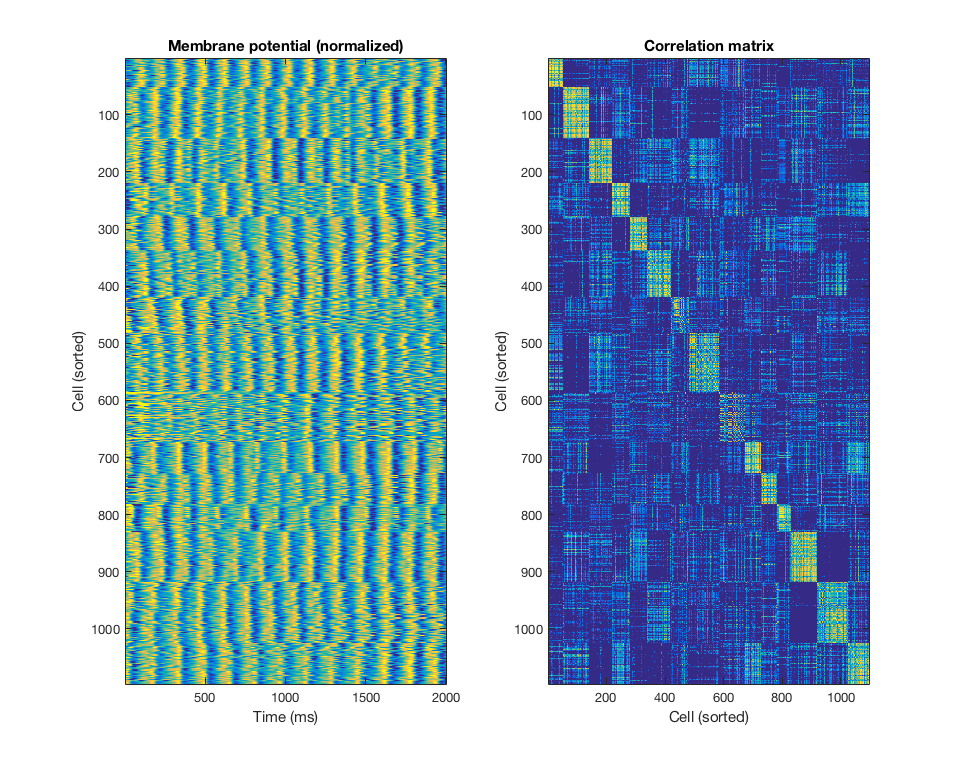

In [140]:
%plot inline -s 1000,800
subplot(121)
imagesc(z4(1:2000, sidx)')
xlabel('Time (ms)')
ylabel('Cell (sorted)')
caxis([-2 2])
title('Membrane potential (normalized)')
subplot(122)
imagesc(zn(sidx, sidx))
xlabel('Cell (sorted)')
ylabel('Cell (sorted)')
title('Correlation matrix')